# Info
Purpose:

    Investigate the Oxygen-A changes when the Aerosol layer varies
    Based on gap analysis from ORACLES

Input:

    None

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - starsun.mat files from ORACLES 2016
  - ORACLES2016_gap_v1.npy:  gap analysis from ORACLES 2016, from ORACLES_AOD_summary_allyears.ipynb

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-02-11
    Modified:


# Prepare python environment

In [2]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from scipy import interpolate

In [3]:
name = 'ORACLES'
vv = 'v1'
fp = getpath(name)


Return path named:  ORACLES /data/sam/ORACLES/


In [4]:
fpo = '/data/sunsat/ORACLES_2016/data_processed/starsuns/R3/'

# Load files

## Load gap files

In [5]:
gap6 = np.load(fp+'ORACLES2016_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap6 = gap6.item()

In [13]:
gap7 = np.load(fp+'ORACLES2017_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap7 = gap7.item()

In [14]:
gap8 = np.load(fp+'ORACLES2018_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap8 = gap8.item()

In [15]:
gap6.keys()

dict_keys(['meas_low_index', 'dlat_ndays', 'dalt', 'dlat', 'aero_base_alt', 'daod', 'aero_base_day', 'dlon', 'meas_low_day', 'aero_base_index', 'aero_base_UTC', 'meas_low_UTC', 'dlon_ndays', 'dang'])

In [9]:
days6 = [d.strftime('%Y%m%d') for d in gap6['aero_base_day']]
day6 = np.unique(days6)

In [10]:
day6

array(['20160827', '20160831', '20160902', '20160904', '20160906',
       '20160908', '20160910', '20160912', '20160914', '20160918',
       '20160920', '20160924', '20160925', '20160927'], dtype='<U8')

In [16]:
days7 = [d.strftime('%Y%m%d') for d in gap7['aero_base_day']]
day7 = np.unique(days7)

In [19]:
days8 = [d.strftime('%Y%m%d') for d in gap8['aero_base_day']]
day8 = np.unique(days8)

## Load starsun files

### Load 2016

In [27]:
s6 = []
for d in day6:
    ss = hs.loadmat(fpo+'4STAR_{}starsun.mat'.format(d),variable_names=['tau_aero','w','t','Pst'])
    ss['filename'] = fpo+'4STAR_{}starsun.mat'.format(d)
    s6.append(ss)

In [28]:
len(s6)

14

In [29]:
s6[0].keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'Pst', 'w', 'tau_aero', 'filename'])

In [30]:
for ss in s6:
    ss['utc'] = lu.mat2py_time(ss['t'])

### Load 2017

In [20]:
fpo7 = '/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/'

In [22]:
s7 = []
for d in day7:
    ss = hs.loadmat(fpo7+'4STAR_{}starsun.mat'.format(d),variable_names=['tau_aero','w','t','Pst'])
    ss['filename'] = fpo7+'4STAR_{}starsun.mat'.format(d)
    print(ss['filename'],'/',len(day7))
    s7.append(ss)

/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170809starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170812starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170813starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170815starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170817starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170818starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170821starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170824starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170826starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170828starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170830starsun.mat / 13
/data/sunsat/ORACLES_2017/data_processed/starsuns/R0/4STAR_20170831starsun.m

In [31]:
for ss in s7:
    ss['utc'] = lu.mat2py_time(ss['t'])

### Load 2018

In [23]:
fpo8 = '/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/'

In [24]:
s8 = []
for d in day8:
    ss = hs.loadmat(fpo8+'4STAR_{}starsun.mat'.format(d),variable_names=['tau_aero','w','t','Pst'])
    ss['filename'] = fpo8+'4STAR_{}starsun.mat'.format(d)
    print(ss['filename'])
    s8.append(ss)

/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20180921starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20180924starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20180927starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20180930starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181002starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181003starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181005starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181007starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181010starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181012starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181015starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0/4STAR_20181017starsun.mat
/data/sunsat/ORACLES_2018/data_processed/starsuns/R0

In [32]:
for ss in s8:
    ss['utc'] = lu.mat2py_time(ss['t'])

## Calculate the Ox-a depth

In [33]:
def oxa_depth(w,spec):
    'calculate the oxygen-a depth. w: wavelenght in microns, spec: spectra(tau_aero)'
    y0 = np.argmin(abs(w-0.756))
    y1 = np.argmin(abs(w-0.772))
    oxa_flat,oxa_delta = [],[]
    for i in range(len(spec)):
        fx = interpolate.interp1d(w[0,[y0,y1]],spec[i,[y0,y1]])
        oxa_flat.append(fx(w[0,y0:y1]))
        oxa_delta.append(np.nansum(spec[i,y0:y1]-oxa_flat))
    return np.array(oxa_delta)

### 2016 Ox-A

In [34]:
for j,ss in enumerate(s6):
    print('Doing file {}, which is {}/{}'.format(day6[j],j,len(s6)))
    if 'oxa_delta' in ss.keys(): 
        print('Yas queen already in there')
        continue
    try:
        ss['oxa_delta'] = oxa_depth(ss['w'],ss['tau_aero'])
    except:
        pass

Doing file 20160827, which is 0/14
Doing file 20160831, which is 1/14
Doing file 20160902, which is 2/14
Doing file 20160904, which is 3/14
Doing file 20160906, which is 4/14
Doing file 20160908, which is 5/14
Doing file 20160910, which is 6/14
Doing file 20160912, which is 7/14
Doing file 20160914, which is 8/14
Doing file 20160918, which is 9/14
Doing file 20160920, which is 10/14
Doing file 20160924, which is 11/14
Doing file 20160925, which is 12/14
Doing file 20160927, which is 13/14


### 2017 Ox-A

In [35]:
for j,ss in enumerate(s7):
    print('Doing file {}, which is {}/{}'.format(day7[j],j,len(s7)))
    if 'oxa_delta' in ss.keys(): 
        print('Yas queen already in there')
        continue
    try:
        ss['oxa_delta'] = oxa_depth(ss['w'],ss['tau_aero'])
    except:
        pass

Doing file 20160827, which is 0/13
Doing file 20160831, which is 1/13
Doing file 20160902, which is 2/13
Doing file 20160904, which is 3/13
Doing file 20160906, which is 4/13
Doing file 20160908, which is 5/13
Doing file 20160910, which is 6/13
Doing file 20160912, which is 7/13
Doing file 20160914, which is 8/13
Doing file 20160918, which is 9/13
Doing file 20160920, which is 10/13
Doing file 20160924, which is 11/13
Doing file 20160925, which is 12/13


### 2018 Ox-A

In [36]:
for j,ss in enumerate(s8):
    print('Doing file {}, which is {}/{}'.format(day8[j],j,len(s8)))
    if 'oxa_delta' in ss.keys(): 
        print('Yas queen already in there')
        continue
    try:
        ss['oxa_delta'] = oxa_depth(ss['w'],ss['tau_aero'])
    except:
        pass

Doing file 20180921, which is 0/17
Doing file 20180924, which is 1/17
Doing file 20180927, which is 2/17
Doing file 20180930, which is 3/17
Doing file 20181002, which is 4/17
Doing file 20181003, which is 5/17
Doing file 20181005, which is 6/17
Doing file 20181007, which is 7/17
Doing file 20181010, which is 8/17
Doing file 20181012, which is 9/17
Doing file 20181015, which is 10/17
Doing file 20181017, which is 11/17
Doing file 20181019, which is 12/17
Doing file 20181021, which is 13/17
Doing file 20181023, which is 14/17
Doing file 20181025, which is 15/17
Doing file 20181026, which is 16/17


## Get the oxa depth for the gap times

In [37]:
dd = gap6['aero_base_day'][1]

In [38]:
utc_fx = lambda x: x.hour+(x.minute+(x.second/60.0))/60.0

In [39]:
s6[iu].keys()

NameError: name 'iu' is not defined

In [40]:
len(gap6['aero_base_alt'])

133

### 2016

In [45]:
n = len(gap6['aero_base_day'])
oxa_aero_base,oxa_meas,press_meas,aod = np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan 
for i,dd in enumerate(gap6['aero_base_day']):
    iu = np.where(day6==days6[i])[0][0]
    it = np.argmin(abs(dd-s6[iu]['utc']))
    try:
        oxa_aero_base[i] = s6[iu]['oxa_delta'][it]
    except KeyError:
        continue
    it2 = np.argmin(abs(gap6['meas_low_day'][i]-s6[iu]['utc']))
    oxa_meas[i] = s6[iu]['oxa_delta'][it2]
    press_meas[i] = s6[iu]['Pst'][it2]
    aod[i] = s6[iu]['tau_aero'][it2,407]

In [42]:
s6[iu]['w'][0,407]

0.500682

### 2017

In [44]:
n = len(gap7['aero_base_day'])
oxa_aero_base7,oxa_meas7,press_meas7,aod7 = np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan 
for i,dd in enumerate(gap7['aero_base_day']):
    iu = np.where(day7==days7[i])[0][0]
    it = np.argmin(abs(dd-s7[iu]['utc']))
    try:
        oxa_aero_base7[i] = s7[iu]['oxa_delta'][it]
    except KeyError:
        continue
    it2 = np.argmin(abs(gap7['meas_low_day'][i]-s7[iu]['utc']))
    oxa_meas7[i] = s7[iu]['oxa_delta'][it2]
    press_meas7[i] = s7[iu]['Pst'][it2]
    aod7[i] = s7[iu]['tau_aero'][it2,407]

### 2018

In [46]:
n = len(gap8['aero_base_day'])
oxa_aero_base8,oxa_meas8,press_meas8,aod8 = np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan 
for i,dd in enumerate(gap8['aero_base_day']):
    iu = np.where(day8==days8[i])[0][0]
    it = np.argmin(abs(dd-s8[iu]['utc']))
    try:
        oxa_aero_base8[i] = s8[iu]['oxa_delta'][it]
    except KeyError:
        continue
    it2 = np.argmin(abs(gap8['meas_low_day'][i]-s8[iu]['utc']))
    oxa_meas8[i] = s8[iu]['oxa_delta'][it2]
    press_meas8[i] = s8[iu]['Pst'][it2]
    aod8[i] = s8[iu]['tau_aero'][it2,407]

# Plot out data

<IPython.core.display.Javascript object>


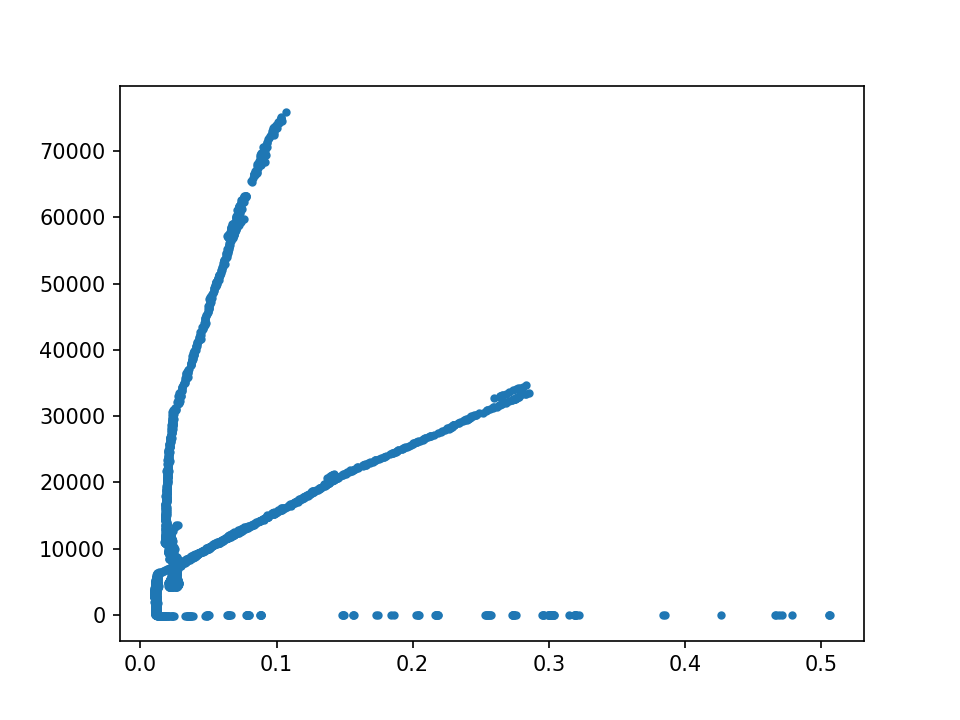

In [56]:
plt.figure()
plt.plot(s6[0]['tau_aero'][:,500],s6[0]['oxa_delta'],'.')

In [47]:
oxa_meas[oxa_meas==0.0] = np.nan

In [48]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


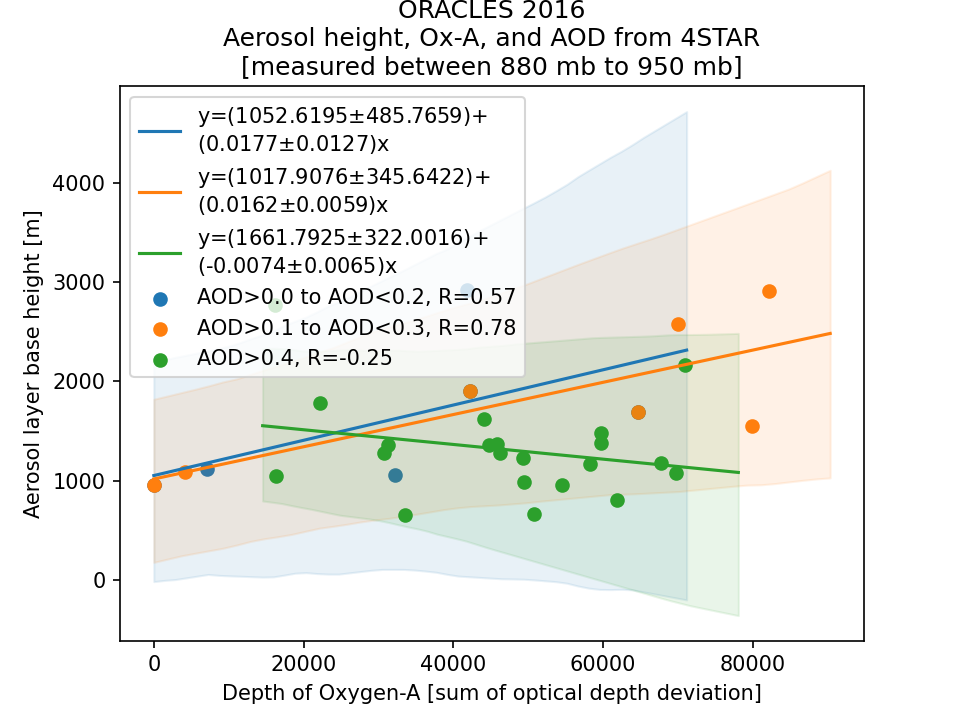

In [90]:
plt.figure()
i_lowa = (press_meas>880.0) & (press_meas<950.0) & (aod>0.0) & (aod<0.2)
plt.scatter(oxa_meas[i_lowa],gap6['aero_base_alt'][i_lowa],
            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowa],oxa_meas[i_lowa])[1,0]))
pu.plot_lin(oxa_meas[i_lowa],gap6['aero_base_alt'][i_lowa],color='tab:blue',lblfmt='2.4f')

i_lowb = (press_meas>880.0) & (press_meas<950.0)& (aod>0.1) & (aod<0.3)
plt.scatter(oxa_meas[i_lowb],gap6['aero_base_alt'][i_lowb],
            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowb],oxa_meas[i_lowb])[1,0]))
pu.plot_lin(oxa_meas[i_lowb],gap6['aero_base_alt'][i_lowb],color='tab:orange',lblfmt='2.4f')

i_lowc = (press_meas>880.0) & (press_meas<950.0) & (aod>0.4)
plt.scatter(oxa_meas[i_lowc],gap6['aero_base_alt'][i_lowc],
            label='AOD>0.4, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowc],oxa_meas[i_lowc])[1,0]))
pu.plot_lin(oxa_meas[i_lowc],gap6['aero_base_alt'][i_lowc],color='tab:green',lblfmt='2.4f')

#i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.6)
#plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],label='AOD>0.6')
#pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:red')
#plt.colorbar(label='Pressure [mb]')
plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.title('ORACLES 2016\nAerosol height, Ox-A, and AOD from 4STAR\n[measured between 880 mb to 950 mb]')
plt.savefig(fp+'ORACLES2016_OXa_vs_aero_alt_{}.png'.format(vv),dpi=600,transparent=True)

In [62]:
press_meas7

array([ 823.09997559,  840.5       ,  875.20001221,  944.79998779,
        878.09997559,  788.5       ,  863.5       ,  887.        ,
        880.20001221,  874.59997559,  880.5       ,  880.40002441,
        892.59997559,  883.29998779,  853.20001221,  947.        ,
        936.        ,  842.40002441, 1012.70001221,  840.5       ,
        854.09997559,  861.70001221,  863.        ,  851.09997559,
        871.70001221,  869.20001221,  843.40002441,  779.09997559,
        928.20001221,  928.79998779,  937.59997559,  913.        ,
        920.59997559,  866.59997559,  876.40002441,  890.09997559,
        973.59997559,  871.70001221,  862.70001221,  886.90002441,
        913.5       ,  969.79998779,  877.70001221,  939.29998779,
        902.        ,  940.59997559,  899.79998779,  928.09997559,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,  839.70001

<IPython.core.display.Javascript object>


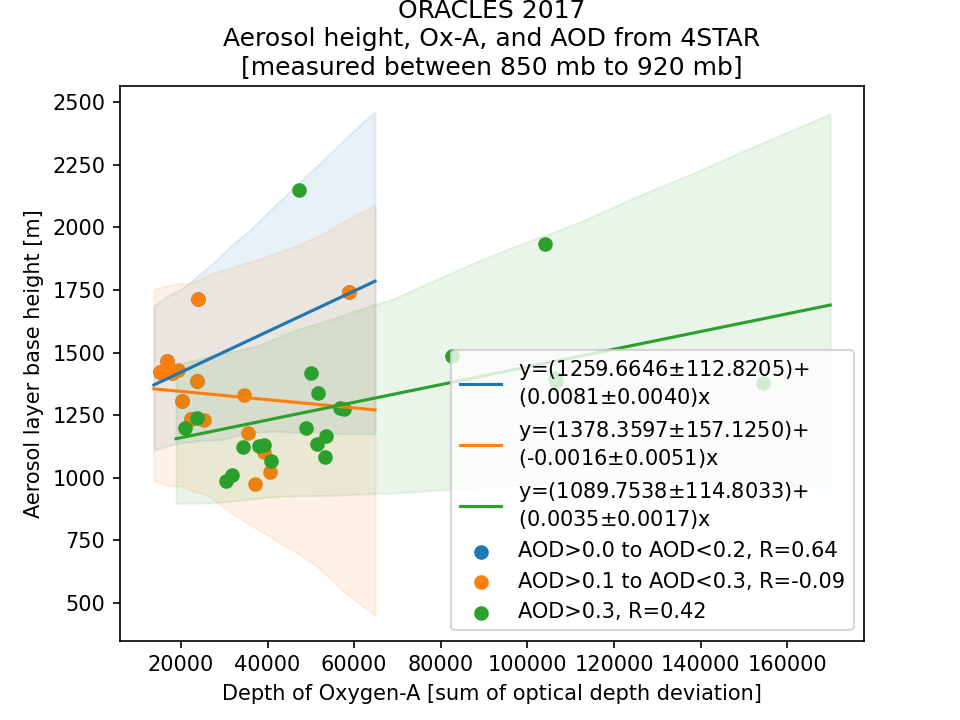

In [89]:
plt.figure()
i_lowa7 = (press_meas7>850.0) & (press_meas7<920.0) & (aod7>0.0) & (aod7<0.25)
plt.scatter(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],
        label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowa7],oxa_meas7[i_lowa7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],color='tab:blue',lblfmt='2.4f')

i_lowb7 = (press_meas7>850.0) & (press_meas7<920.0)& (aod7>0.1) & (aod7<0.3)
plt.scatter(oxa_meas7[i_lowb7],gap7['aero_base_alt'][i_lowb7],
        label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowb7],oxa_meas7[i_lowb7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowb7],gap7['aero_base_alt'][i_lowb7],color='tab:orange',lblfmt='2.4f')

i_lowc7 = (press_meas7>850.0) & (press_meas7<920.0) & (aod7>0.3)
plt.scatter(oxa_meas7[i_lowc7],gap7['aero_base_alt'][i_lowc7],
        label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowc7],oxa_meas7[i_lowc7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowc7],gap7['aero_base_alt'][i_lowc7],color='tab:green',lblfmt='2.4f')

#i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.6)
#plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],label='AOD>0.6')
#pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:red')
#plt.colorbar(label='Pressure [mb]')
plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.title('ORACLES 2017\nAerosol height, Ox-A, and AOD from 4STAR\n[measured between 850 mb to 920 mb]')
plt.savefig(fp+'ORACLES2017_OXa_vs_aero_alt_850mb_{}.png'.format(vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


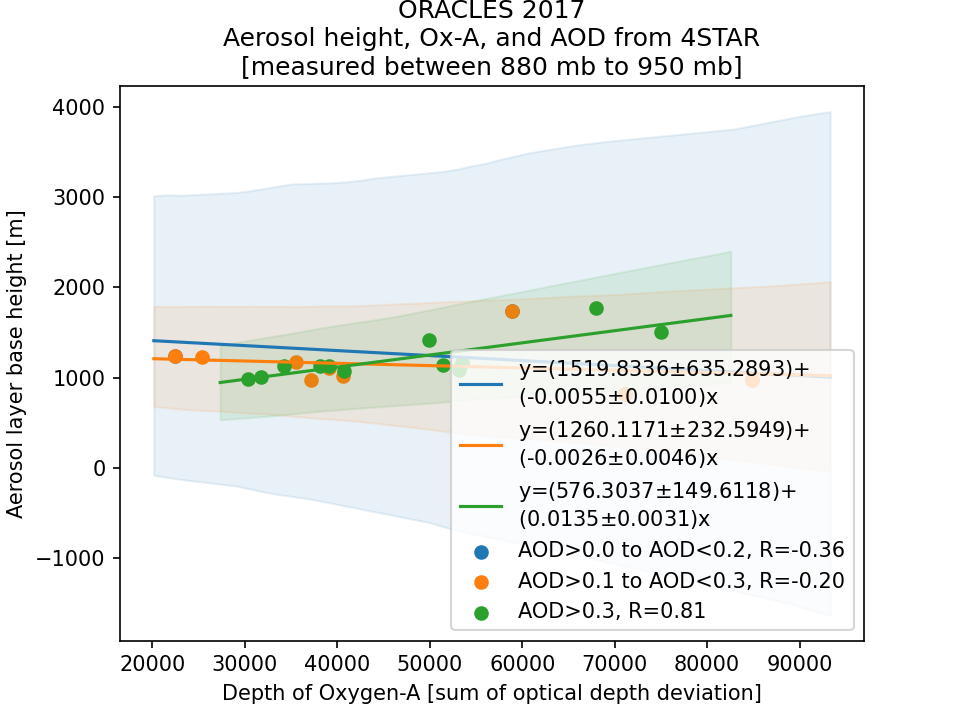

In [88]:
plt.figure()
i_lowa7 = (press_meas7>880.0) & (press_meas7<950.0) & (aod7>0.0) & (aod7<0.25)
plt.scatter(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],
        label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowa7],oxa_meas7[i_lowa7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],color='tab:blue',lblfmt='2.4f')

i_lowb7 = (press_meas7>880.0) & (press_meas7<950.0)& (aod7>0.1) & (aod7<0.3)
plt.scatter(oxa_meas7[i_lowb7],gap7['aero_base_alt'][i_lowb7],
        label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowb7],oxa_meas7[i_lowb7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowb7],gap7['aero_base_alt'][i_lowb7],color='tab:orange',lblfmt='2.4f')

i_lowc7 = (press_meas7>880.0) & (press_meas7<950.0) & (aod7>0.3)
plt.scatter(oxa_meas7[i_lowc7],gap7['aero_base_alt'][i_lowc7],
        label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowc7],oxa_meas7[i_lowc7])[1,0]))
pu.plot_lin(oxa_meas7[i_lowc7],gap7['aero_base_alt'][i_lowc7],color='tab:green',lblfmt='2.4f')

#i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.6)
#plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],label='AOD>0.6')
#pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:red')
#plt.colorbar(label='Pressure [mb]')
plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.title('ORACLES 2017\nAerosol height, Ox-A, and AOD from 4STAR\n[measured between 880 mb to 950 mb]')
plt.savefig(fp+'ORACLES2017_OXa_vs_aero_alt_{}.png'.format(vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


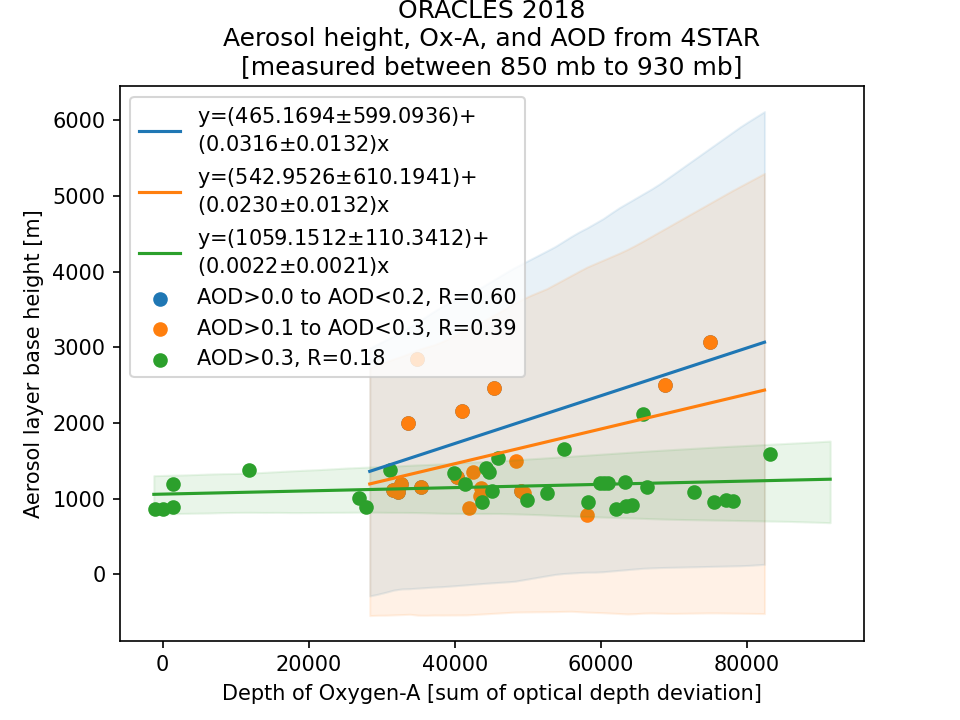

In [87]:
plt.figure()
i_lowa8 = (press_meas8>850.0) & (press_meas8<930.0) & (aod8>0.0) & (aod8<0.25)
plt.scatter(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],
            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowa8],oxa_meas8[i_lowa8])[1,0]))
pu.plot_lin(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],color='tab:blue',lblfmt='2.4f')

i_lowb8 = (press_meas8>850.0) & (press_meas8<930.0)& (aod8>0.1) & (aod8<0.3)
plt.scatter(oxa_meas8[i_lowb8],gap8['aero_base_alt'][i_lowb8],
            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowb8],oxa_meas8[i_lowb8])[1,0]))
pu.plot_lin(oxa_meas8[i_lowb8],gap8['aero_base_alt'][i_lowb8],color='tab:orange',lblfmt='2.4f')

i_lowc8 = (press_meas8>850.0) & (press_meas8<930.0) & (aod8>0.3)
plt.scatter(oxa_meas8[i_lowc8],gap8['aero_base_alt'][i_lowc8],
            label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowc8],oxa_meas8[i_lowc8])[1,0]))
pu.plot_lin(oxa_meas8[i_lowc8],gap8['aero_base_alt'][i_lowc8],color='tab:green',lblfmt='2.4f')

#i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.6)
#plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],label='AOD>0.6')
#pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:red')
#plt.colorbar(label='Pressure [mb]')
plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.title('ORACLES 2018\nAerosol height, Ox-A, and AOD from 4STAR\n[measured between 850 mb to 930 mb]')
plt.savefig(fp+'ORACLES2018_OXa_vs_aero_alt_{}.png'.format(vv),dpi=600,transparent=True)

In [69]:
gap8['aero_base_alt']

array([ 779.8,  177.3, 1164. , 3066.8, 2507.6,  623. , 1136.2,  914.4,
       1221.1, 1409.1, 1103.7,  977.9,  930.1, 1278.7, 1355.6, 2850.7,
       1187.1,  887. ,  856.5,  859.7, 1183.9,  815.6,  762. ,  928.7,
        956.5, 1208.8, 1204. , 1208.8, 1367.5,  968.7,   79.9,  543.3,
        974.4,  960.1,  979.4, 2162.6, 1596.1, 1155.4, 1148.4, 1084. ,
        831.1,  967.4, 1584.4,  860.3, 1726.8,  750.3, 2162.7,  277.3,
       1010.2,  891. ,  738.1,  340.4, 1373.8, 1036.3,  873.5, 1650.5,
        621.8,  846.6,  873.7,  900.4,  862.2, 1023.3, 1061.3,  541.2,
       1069.8, 1354.1, 1339.9, 1191.2,  955.8, 1172. ,  141.6, 1537.8,
       1511.1, 2115.1, 1399.3, 2150.4, 1652. , 2702. , 1374.6, 1537.1,
       1615.4, 1819. , 1245.6,  880.5, 1136.6, 1288.7, 1134.2, 1168.8,
       1079.5, 1503. , 1739.1, 2220.1, 1550.2, 1525.7, 1306.4, 2506.2,
       1925.5, 2228.5, 2460.9, 1025.8, 1101.6,  782.6,  406.5, 2498.5,
        519. , 1034.4,  891.7,  876.8, 1811.7, 1993.3, 2053.4, 1727.9,
      

## Combined plots

In [100]:
np.append(np.append(oxa_meas[i_lowa],oxa_meas7[i_lowa7]),oxa_meas8[i_lowa8])

array([7.15659277e+03, 4.22502969e+04, 4.17795078e+04, 6.46835156e+04,
       2.83642340e+00, 3.22679121e+04, 2.23925801e+04, 2.01973340e+04,
       1.52664736e+04, 1.79574785e+04, 1.67532676e+04, 5.89154023e+04,
       2.36701699e+04, 2.38676914e+04, 7.49149531e+04, 6.87956250e+04,
       3.48634453e+04, 4.09869961e+04, 4.02459609e+04, 4.53409766e+04,
       4.91167344e+04, 3.35235508e+04, 3.15022070e+04, 3.22358340e+04,
       3.53424648e+04, 3.26882324e+04])

<IPython.core.display.Javascript object>


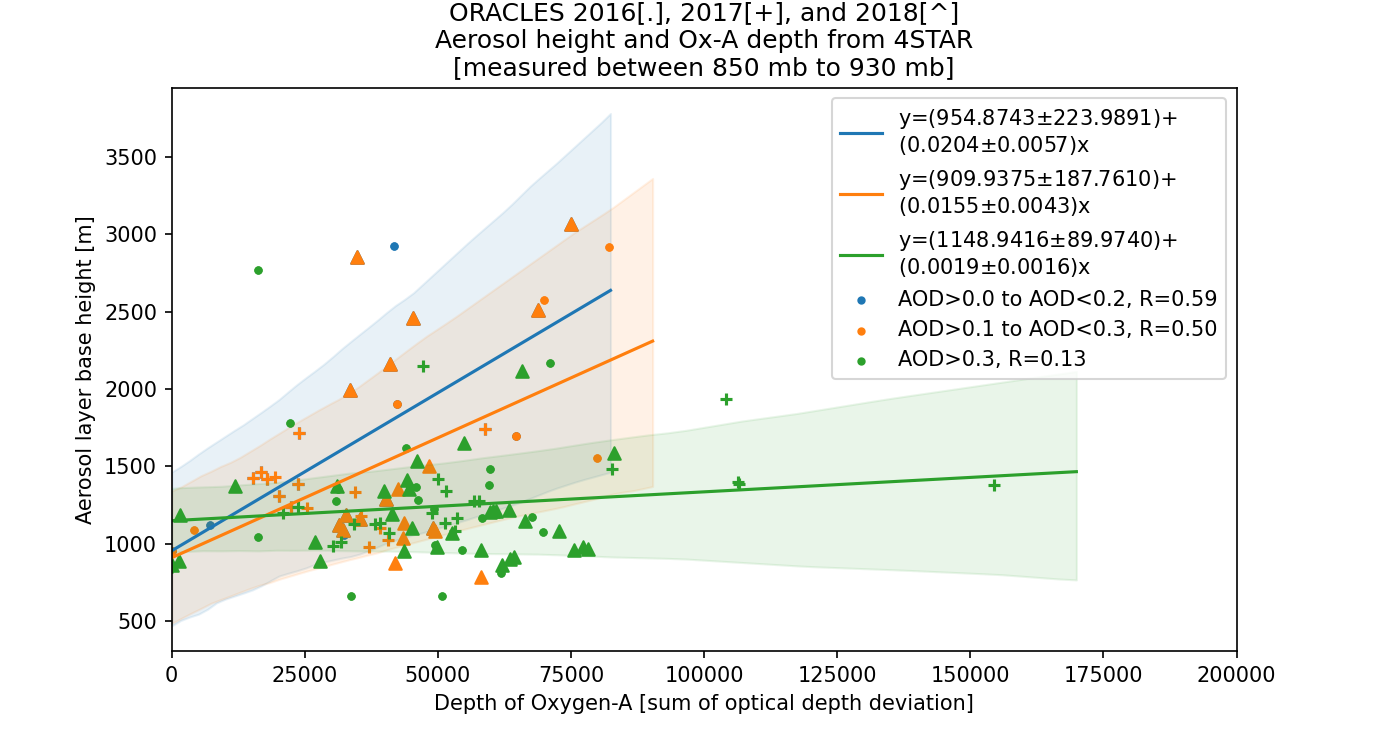

In [116]:
plt.figure()

plt.scatter(oxa_meas[i_lowa],gap6['aero_base_alt'][i_lowa],marker='.',color='tab:blue')
#            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowa],oxa_meas[i_lowa])[1,0]))
plt.scatter(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],marker='+',color='tab:blue')
#        label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowa7],oxa_meas7[i_lowa7])[1,0]))
#pu.plot_lin(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],color='tab:blue',lblfmt='2.4f')
plt.scatter(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],marker='^',color='tab:blue')
#            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowa8],oxa_meas8[i_lowa8])[1,0]))
#pu.plot_lin(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],color='tab:blue',lblfmt='2.4f')

oxa_a = np.append(np.append(oxa_meas[i_lowa],oxa_meas7[i_lowa7]),oxa_meas8[i_lowa8])
bas_a = np.append(np.append(gap6['aero_base_alt'][i_lowa],gap7['aero_base_alt'][i_lowa7]),gap8['aero_base_alt'][i_lowa8])
plt.scatter(oxa_meas[i_lowa],gap6['aero_base_alt'][i_lowa],marker='.',color='tab:blue',
            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(bas_a,oxa_a)[1,0]))
pu.plot_lin(oxa_a,bas_a,color='tab:blue',lblfmt='2.4f')

plt.scatter(oxa_meas[i_lowb],gap6['aero_base_alt'][i_lowb],marker='.',color='tab:orange')
#            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowb],oxa_meas[i_lowb])[1,0]))
plt.scatter(oxa_meas7[i_lowb7],gap7['aero_base_alt'][i_lowb7],marker='+',color='tab:orange')
#        label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowb7],oxa_meas7[i_lowb7])[1,0]))
#pu.plot_lin(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],color='tab:blue',lblfmt='2.4f')
plt.scatter(oxa_meas8[i_lowb8],gap8['aero_base_alt'][i_lowb8],marker='^',color='tab:orange')
#            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowb8],oxa_meas8[i_lowb8])[1,0]))
#pu.plot_lin(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],color='tab:blue',lblfmt='2.4f')
plt.scatter(oxa_meas[i_lowb],gap6['aero_base_alt'][i_lowb],marker='.',color='tab:orange', 
            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(bas_b,oxa_b)[1,0]))

oxa_b = np.append(np.append(oxa_meas[i_lowb],oxa_meas7[i_lowb7]),oxa_meas8[i_lowb8])
bas_b = np.append(np.append(gap6['aero_base_alt'][i_lowb],gap7['aero_base_alt'][i_lowb7]),gap8['aero_base_alt'][i_lowb8])

pu.plot_lin(oxa_b,bas_b,color='tab:orange',lblfmt='2.4f')

plt.scatter(oxa_meas[i_lowc],gap6['aero_base_alt'][i_lowc],marker='.',color='tab:green')
#            label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_lowc],oxa_meas[i_lowc])[1,0]))
plt.scatter(oxa_meas7[i_lowc7],gap7['aero_base_alt'][i_lowc7],marker='+',color='tab:green')
#        label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap7['aero_base_alt'][i_lowc7],oxa_meas7[i_lowc7])[1,0]))
#pu.plot_lin(oxa_meas7[i_lowa7],gap7['aero_base_alt'][i_lowa7],color='tab:blue',lblfmt='2.4f')
plt.scatter(oxa_meas8[i_lowc8],gap8['aero_base_alt'][i_lowc8],marker='^',color='tab:green')
#            label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(gap8['aero_base_alt'][i_lowc8],oxa_meas8[i_lowc8])[1,0]))
#pu.plot_lin(oxa_meas8[i_lowa8],gap8['aero_base_alt'][i_lowa8],color='tab:blue',lblfmt='2.4f')

oxa_c = np.append(np.append(oxa_meas[i_lowc],oxa_meas7[i_lowc7]),oxa_meas8[i_lowc8])
bas_c = np.append(np.append(gap6['aero_base_alt'][i_lowc],gap7['aero_base_alt'][i_lowc7]),gap8['aero_base_alt'][i_lowc8])
plt.scatter(oxa_meas[i_lowc],gap6['aero_base_alt'][i_lowc],marker='.',color='tab:green',
            label='AOD>0.3, R={:1.2f}'.format(np.corrcoef(bas_c,oxa_c)[1,0]))
pu.plot_lin(oxa_c,bas_c,color='tab:green',lblfmt='2.4f')

plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.xlim(0,200000)
plt.title('ORACLES 2016[.], 2017[+], and 2018[^]\nAerosol height and Ox-A depth from 4STAR\n[measured between 850 mb to 930 mb]')
plt.savefig(fp+'ORACLES_all_OXa_vs_aero_alt_{}.png'.format(vv),dpi=600,transparent=True)
